In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install hazm

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git 
! pip install transformers 
! pip install arabic-reshaper
! pip install python-bidi 

In [4]:
! pip install -q kaggle

In [5]:
import os
os.environ['KAGGLE_USERNAME'] = "shafieiali666"
os.environ['KAGGLE_KEY'] = "2a72371e7748b1c2a39075b67b207030"

In [6]:
!kaggle datasets download -d sajjadayobi360/flickrfa

 99% 3.48G/3.50G [00:44<00:00, 87.0MB/s]
100% 3.50G/3.50G [00:44<00:00, 85.2MB/s]


In [ ]:
! unzip flickrfa.zip

In [8]:
from __future__ import unicode_literals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import time
import copy
import PIL
import torch
import os
import clip
import requests
from PIL import Image
import torch.nn as nn
import multiprocessing
from tqdm import tqdm
from io import BytesIO
import torchvision.transforms as transforms
from torch.cuda.amp import autocast
from transformers import CLIPModel, CLIPConfig, CLIPVisionModel, CLIPFeatureExtractor
from transformers import AutoModel, AutoTokenizer, AutoModel, TFAutoModel, AutoConfig
from transformers import BertModel
from transformers import TrainingArguments, Trainer, RobertaModel
from transformers import default_data_collator
from IPython.display import clear_output


In [9]:
df = pd.read_csv('dataset.csv')
df = df.dropna()
df = df.reset_index(drop=True)
# df=df[:100]
print(df.shape)
df.head()

(32382, 2)


,caption,image
0,دو مرد با پیراهن سبز در حیاط ایستاده اند.,1000092795.jpg
1,سه مرد روی یک دکل بزرگ.,10002456.jpg
2,دختر بچه ای در حال بالا رفتن از یک خانه بازی چوبی,1000268201.jpg
3,مردی روی نردبان پنجره ای را تمیز می کند,1000344755.jpg
4,دو مرد در حال پختن غذا هستند.,1000366164.jpg


In [10]:
images_list_final = np.array([f"images/{i}" for i in df['image']])
text_list_final = np.array([i for i in df['caption']])

In [12]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
model, preprocess = clip.load("ViT-L/14", device=device, jit=False)
model = model.float()
parsbert_path = "HooshvareLab/bert-fa-zwnj-base"
config = AutoConfig.from_pretrained(parsbert_path)
tokenizer = AutoTokenizer.from_pretrained(parsbert_path)
parsbert = BertModel.from_pretrained(parsbert_path).float().to(device)

In [14]:
def my_encode_text(text):
    return parsbert(text).pooler_output
model.encode_text = my_encode_text
model.transformer = parsbert

In [15]:
for i in range(df.shape[0]):
  df.iloc[i]["image"]="images/"+df.iloc[i]["image"]
df.head()

,caption,image
0,دو مرد با پیراهن سبز در حیاط ایستاده اند.,images/1000092795.jpg
1,سه مرد روی یک دکل بزرگ.,images/10002456.jpg
2,دختر بچه ای در حال بالا رفتن از یک خانه بازی چوبی,images/1000268201.jpg
3,مردی روی نردبان پنجره ای را تمیز می کند,images/1000344755.jpg
4,دو مرد در حال پختن غذا هستند.,images/1000366164.jpg


## DataLoader

In [17]:
import os
import pandas as pd  
import torch
from torch.nn.utils.rnn import pad_sequence 
from torch.utils.data import DataLoader, Dataset
from PIL import Image 
import torchvision.transforms as transforms
import hazm
from hazm import *

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)


    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in word_tokenize(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = word_tokenize(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


In [18]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
BATCH_SIZE = 64

class ImageCaptionDataset(Dataset):
    def __init__(self, all_images, all_captions,freq_threshold=3):
        self.all_images = all_images
        self.all_captions=all_captions
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.all_captions)


    def __len__(self):
        return len(self.all_captions)

    def __getitem__(self, index):
        image = preprocess(Image.open(self.all_images[index]))
        caption = self.all_captions[index]
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        return image, torch.tensor(numericalized_caption)

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.15, shuffle=True, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, shuffle=True, random_state=42)

In [21]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets



In [22]:
def get_loader(
    images,
    captions,
    batch_size=64,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):

    dataset = ImageCaptionDataset(images,captions)
    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )
    return loader, dataset



train_dataloader, train_dataset = get_loader(train_df['image'].tolist(), train_df['caption'].tolist())
test_dataloader,test_dataset = get_loader(test_df['image'].tolist(), test_df['caption'].tolist())
val_dataloader,val_dataset = get_loader(val_df['image'].tolist(), val_df['caption'].tolist())

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Image captioning

In [ ]:
EPOCH = 10
LR = 1e-7
EPS = 1e-9
WEIGHT_DECAY = 0.1
MAX_LR = 1e-2
BASE_MODEL_PATH = 'drive/MyDrive/Nlp_HW3/models/'
loss_img = nn.CrossEntropyLoss()
loss_captions = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), 
                             lr=LR,
                             betas=(0.9,0.98),
                             eps=EPS,
                             weight_decay=WEIGHT_DECAY) 

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=MAX_LR, 
                                                steps_per_epoch=len(train_dataloader), 
                                                epochs=EPOCH)

model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)


In [ ]:
import torch
import torch.nn as nn
import statistics


class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.fc=nn.Linear(768, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        with torch.no_grad():
          features = model.encode_image(images)
        return self.dropout(self.relu(self.fc(features)))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image.unsqueeze(0)).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

## Training

In [27]:
import torch.optim as optim
embed_size = 256
hidden_size = 256
vocab_size = len(train_dataset.vocab)
num_layers = 1
learning_rate = 3e-4
image_cpationing_model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
image_cpationing_model.train()
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(image_cpationing_model.parameters(), lr=learning_rate)


In [28]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

def train_model(image_cpationing_model,optimizer,current_epoch,num_epochs=100):
    step = 0
    print("training ....")
    train_loss=0
    iter_cnt=0
    for epoch in range(current_epoch,num_epochs):

      print(f"Epoch {epoch+1}/{num_epochs}")
      print()
      print("training ....")
      train_loss=0
      iter_cnt=0
      for batch in tqdm(train_dataloader):
        images,captions=batch
        images=images.to(device)
        captions=captions.to(device)
        optimizer.zero_grad()
          
        outputs = image_cpationing_model(images, captions[:-1])
        batch_loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

        step += 1
        train_loss+=batch_loss
        iter_cnt+=1

        batch_loss.backward()
        optimizer.step()
      epoch_loss=train_loss/iter_cnt
      print(f'Train Loss: {epoch_loss:.4f}') 
      torch.save({'model_state_dict': image_cpationing_model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),"step": step,}, BASE_MODEL_PATH+f'checkpoint_ep_captioning{epoch}.pt')
   # -------------------------------------------------------------------------------------------------------------------------
      print("validation ....")
      val_loss=0
      iter_cnt=0
      for batch in tqdm(val_dataloader):
        images,captions=batch
        images=images.to(device)
        captions=captions.to(device)  
        optimizer.zero_grad()
        with torch.no_grad():
          outputs = image_cpationing_model(images, captions[:-1])
          batch_loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
        val_loss+=batch_loss
        iter_cnt+=1
      epoch_loss=val_loss/iter_cnt
      print(f'Validation Loss: {epoch_loss:.4f}')

In [29]:
image_cpationing_model

CNNtoRNN(
  (encoderCNN): EncoderCNN(
    (fc): Linear(in_features=768, out_features=256, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoderRNN): DecoderRNN(
    (embed): Embedding(4781, 256)
    (lstm): LSTM(256, 256)
    (linear): Linear(in_features=256, out_features=4781, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
train_model(image_cpationing_model, optimizer=optimizer, current_epoch=0,num_epochs=100)

## Output Examples


In [57]:
checkpoint2 = torch.load(BASE_MODEL_PATH+f'checkpoint_ep_captioning{36}.pt')
image_cpationing_model.load_state_dict(checkpoint2['model_state_dict'])


<All keys matched successfully>

In [58]:
image_cpationing_model

CNNtoRNN(
  (encoderCNN): EncoderCNN(
    (fc): Linear(in_features=768, out_features=256, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoderRNN): DecoderRNN(
    (embed): Embedding(4781, 256)
    (lstm): LSTM(256, 256)
    (linear): Linear(in_features=256, out_features=4781, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def print_examples(image_cpationing_model,index):
    image_cpationing_model.eval()
    test_img1 = train_dataset[index][0]
    
    print(train_dataset[index][1])
    a=train_dataset[index][1]
    s=""
    for tok in a:
      s=s+" "+train_dataset.vocab.itos[tok.item()]
    print(s)
    print(f"Output: {image_cpationing_model.caption_image(test_img1.to(device), train_dataset.vocab)}")

In [61]:
def show_image_caption(query_index,query_string):
  indexes_list=[]
  for i in range(len(df)):
    if query_string in df.iloc[i]["caption"]:
      indexes_list.append(i)
  plt.imshow(plt.imread(df.iloc[indexes_list]["image"].tolist()[0]))
  print_examples(image_cpationing_model,query_index)

tensor([  1,  12, 126, 262,  12, 169,  91, 169, 170,  13,  30,   6,   2])
 <SOS> یک نفر زیر یک موج بزرگ موج سواری می کند . <EOS>
Output: ['<SOS>', 'مردی', 'با', 'پیراهن', 'آبی', 'در', 'حال', 'پریدن', 'از', 'روی', 'تخته', 'موج', 'سواری', 'است', '.', '<EOS>']


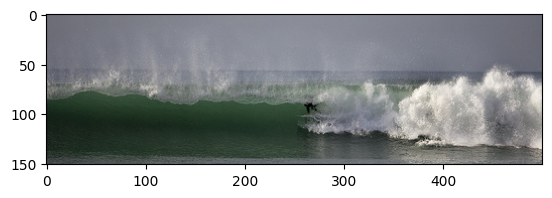

In [62]:
show_image_caption(8,"یک نفر زیر یک موج بزرگ")

tensor([  1,  46,  24,   4, 179,  47,  13,  34,  16,  24,  48,  49,  87,  27,
         13,  99,   6,   2])
 <SOS> سه سگ در پارک بازی می کنند و سگ قهوه ای توپ را می گیرد . <EOS>
Output: ['<SOS>', 'سه', 'سگ', 'در', 'حال', 'بازی', 'در', 'چمن', '.', '<EOS>']


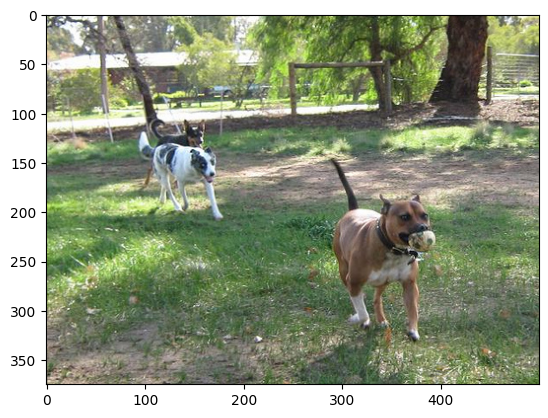

In [63]:
show_image_caption(52,"سه سگ در پارک بازی می کنند و سگ قهوه ای")

tensor([   1, 1644,    7,    4,   12,  234,    4,   11, 3664,   20,    6,    2])
 <SOS> بازاری که در یک پارکینگ در حال وقوع است . <EOS>
Output: ['<SOS>', 'مردم', 'در', 'یک', 'بازار', 'شلوغ', 'در', 'فضای', 'باز', '.', '<EOS>']


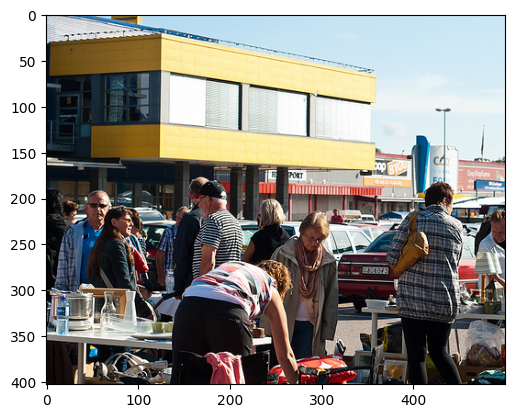

In [64]:
show_image_caption(34,"بازاری که در یک پارکینگ")

tensor([  1,  12,  60,  16,  26,  21,  15, 222, 223,   4,  90,  14, 134,   6,
          2])
 <SOS> یک مرد و دو کودک با جلیقه نجات در قایق روی دریاچه . <EOS>
Output: ['<SOS>', 'دو', 'نفر', 'در', 'حال', 'پارو', 'زدن', 'در', 'یک', 'قایق', 'هستند', '.', '<EOS>']


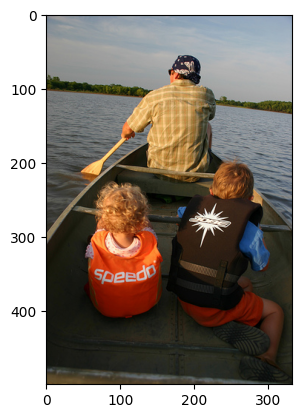

In [66]:
show_image_caption(101,"یک مرد و دو کودک با جلیقه نجات")

tensor([   1,  265,    4,  260,   83, 3596,    2])
 <SOS> جنگل در نزدیکی کوه گرانیتی <EOS>
Output: ['<SOS>', 'کوه', 'های', 'برفی', '<EOS>']


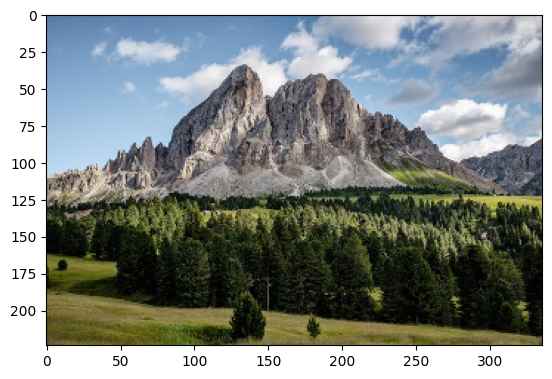

In [69]:
show_image_caption(1,"جنگل در نزدیکی کوه گرانیتی")

tensor([  1, 715, 730,   4,  12,  83, 174,   6,   2])
 <SOS> اسکی بازان در یک کوه برفی . <EOS>
Output: ['<SOS>', 'یک', 'اسکی', 'باز', 'در', 'حال', 'اسکی', 'کردن', 'از', 'تپه', 'ای', 'برفی', 'است', '.', '<EOS>']


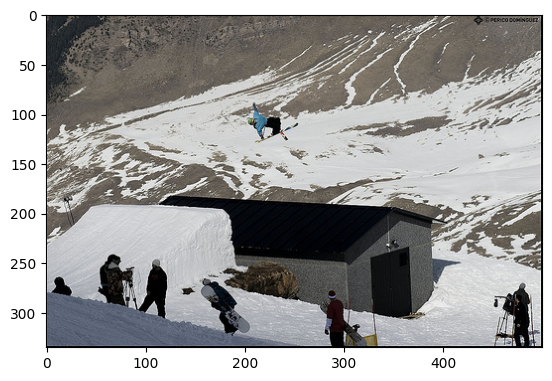

In [80]:
show_image_caption(9,"اسکی بازان در یک کوه برفی")

tensor([   1,  110, 4307,   14,  157,   13,  501,    6,    2])
 <SOS> چهار بالرین روی صحنه می رقصند . <EOS>
Output: ['<SOS>', 'گروهی', 'از', 'زنان', 'در', 'حال', 'رقصیدن', 'در', 'یک', 'سالن', 'رقص', 'هستند', '.', '<EOS>']


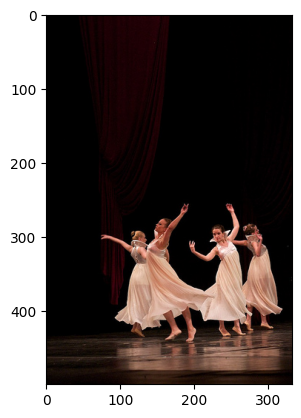

In [86]:
show_image_caption(12,"چهار بالرین روی صحنه می رقصند")

tensor([   1,   46,   21,   14, 4025,    5,   16, 2792,   13,   34,    7,  561,
          13,  147,    6,    2])
 <SOS> سه کودک روی فرشی هستند و وانمود می کنند که ساز می زنند . <EOS>
Output: ['<SOS>', 'سه', 'دختر', 'جوان', 'در', 'حال', 'بازی', 'با', 'یکدیگر', '.', '<EOS>']


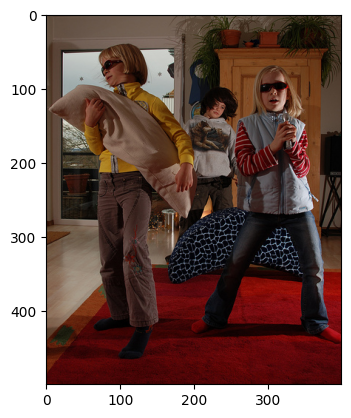

In [96]:
show_image_caption(20,"سه کودک روی فرشی هستند و وانمود می کنند که ساز می زنند")